In [22]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3

from prompts import chat_prompt


In [23]:
load_dotenv()

True

In [24]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

In [25]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [26]:
def chat_assistant(state: ChatState) -> dict:
    prompt = ChatPromptTemplate.from_messages({
        ("system", chat_prompt),
        ("user", "{messages}")
    })

    chat_chain = prompt | llm

    result = chat_chain.invoke({"messages" : state["messages"]})

    return {"messages" : [result]}

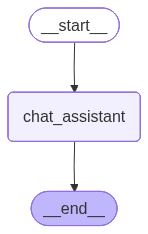

In [27]:
graph = StateGraph(ChatState)

graph.add_node("chat_assistant", chat_assistant)

graph.add_edge(START, "chat_assistant")
graph.add_edge("chat_assistant", END)

conn = sqlite3.connect("database/convo_graph.db", check_same_thread=False)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)
workflow 

In [28]:
workflow.invoke({"messages": "my name is Rishabh Singh"}, config={"configurable": {"thread_id" : 1}})

{'messages': [HumanMessage(content='my name is Rishabh Singh', additional_kwargs={}, response_metadata={}, id='f2a95193-aae0-4df9-823d-f099990e41c9'),
  AIMessage(content="Hello Rishabh! It's great to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7acc52f5-8370-4b03-8458-345b4a367248-0', usage_metadata={'input_tokens': 167, 'output_tokens': 51, 'total_tokens': 218, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 32}})]}

In [29]:
workflow.invoke({"messages": "What is my name"}, config={"configurable": {"thread_id" : 1}})

{'messages': [HumanMessage(content='my name is Rishabh Singh', additional_kwargs={}, response_metadata={}, id='f2a95193-aae0-4df9-823d-f099990e41c9'),
  AIMessage(content="Hello Rishabh! It's great to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--7acc52f5-8370-4b03-8458-345b4a367248-0', usage_metadata={'input_tokens': 167, 'output_tokens': 51, 'total_tokens': 218, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 32}}),
  HumanMessage(content='What is my name', additional_kwargs={}, response_metadata={}, id='865f0439-e7a1-4d7f-9392-df3a8bdb74e3'),
  AIMessage(content='Your name is Rishabh Singh.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name'